In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import r2_score
from LinearRegressionModel import MyModel
import pickle
import warnings
warnings.filterwarnings('ignore')

# Data Understanding

In [3]:
cars = pd.read_csv("car_price.csv")
cars.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


In [4]:
# Check datatype
cars.dtypes

Unnamed: 0              int64
car_name               object
car_prices_in_rupee    object
kms_driven             object
fuel_type              object
transmission           object
ownership              object
manufacture             int64
engine                 object
Seats                  object
dtype: object

In [5]:
# Check Missing value
cars.isnull().sum()

Unnamed: 0             0
car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

**NO MISSING VALUE IS AVALIABLE**

In [11]:
# Check Duplication
cars.duplicated().sum()

0

**NO DUPLICATON**

In [14]:
# Check the number of unique values of each column
cars.nunique()

Unnamed: 0             5512
car_name               1896
car_prices_in_rupee    1300
kms_driven             2610
fuel_type                 5
transmission              2
ownership                 6
manufacture              26
engine                  139
Seats                     6
dtype: int64

In [16]:
columns=['fuel_type', 'transmission','Seats','ownership','manufacture']

for column in columns:  
    print(f"Category in {column} is : {cars[column].unique()}")

Category in fuel_type is : ['Diesel' 'Petrol' 'Cng' 'Electric' 'Lpg']
Category in transmission is : ['Manual' 'Automatic']
Category in Seats is : ['5 Seats' '6 Seats' '7 Seats' '4 Seats' '8 Seats' '2 Seats']
Category in ownership is : ['1st Owner' '2nd Owner' '3rd Owner' '4th Owner' '5th Owner' '0th Owner']
Category in manufacture is : [2017 2021 2016 2018 2015 2014 2020 2019 2012 2008 2013 2022 2010 2005
 2009 2006 2011 2007 2002 2004 1998 2003 1995 2000 2001 1999]


# Data Cleaning
- Clean kms driven as it has object values with kms at last and has commans in it's values
- Change kms driven type to float 
- Clean engine as it has object values with cc at last.
- Change engine type to int.
- Clean Seats as it has object values with Seats at last.
- Change Seats type to int.
- Clean ownership as it has object values with Owner at last and the values are Ordinal numbers.
- Change ownership type to int.
- Clean Price as it has object values with Lakh,Thousand,Crore at last and has commans in it's values.
- Convert Price in to Thousands and change its type to int.
- Drop Unnamed: 0 columnnan values

In [19]:
cars["kms_driven"] = cars["kms_driven"].apply(lambda x: x.split(" ")[0].replace(",","")).astype(float)

cars["engine"] = cars["engine"].apply(lambda x: x.split(" ")[0]).astype(int)

cars["Seats"] = cars["Seats"].apply(lambda x: x.split(" ")[0]).astype(int)

cars["ownership"] = cars["ownership"].apply(lambda x: list(x)[0]).astype(int)

def convert_price(price):
    if 'Lakh' in price:
        return int(float(price.split()[0])*100000)
    elif 'Crore' in price:
        return int(float(price.split()[0])*10000000)
    else:
        return int(price)

cars["car_prices_in_rupee"] = cars["car_prices_in_rupee"].str.replace(",","").apply(convert_price)

cars = cars[["car_name","car_prices_in_rupee","kms_driven","fuel_type","transmission","ownership","manufacture","engine","Seats"]]

In [21]:
# Check datatype after data cleaning
cars.dtypes

car_name                object
car_prices_in_rupee      int64
kms_driven             float64
fuel_type               object
transmission            object
ownership                int32
manufacture              int64
engine                   int32
Seats                    int32
dtype: object

In [23]:
# Check Missing value after data cleaning
cars.isnull().sum()

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

**NO MISSING VALUE IS AVALIABLE**

In [26]:
# Check Duplication after data cleaning
cars.duplicated().sum()

76

**76 DUPLICATES**

In [29]:
# Remove duplicates
cars.drop_duplicates(inplace=True)
cars.reset_index(drop=True,inplace=True)

**DUPLICATES REMOVED**

In [32]:
# Check statistics of cleaned data set
cars.describe()

,car_prices_in_rupee,kms_driven,ownership,manufacture,engine,Seats
count,5.436000e+03,5436.000000,5436.000000,5436.000000,5436.000000,5436.000000
mean,1.151290e+06,63343.080390,1.424577,2015.437822,1532.926784,5.252208
std,1.953077e+06,41961.414723,0.705358,3.938207,580.933381,0.722515
min,3.500000e+04,250.000000,0.000000,1995.000000,0.000000,2.000000
25%,3.130000e+05,33234.000000,1.000000,2013.000000,1197.000000,5.000000
50%,5.500000e+05,59290.000000,1.000000,2016.000000,1396.000000,5.000000
75%,1.020249e+06,84363.000000,2.000000,2018.000000,1950.000000,5.000000
max,1.920000e+07,560000.000000,5.000000,2022.000000,5950.000000,8.000000


# Cleaned Data

In [35]:
cars

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,Jeep Compass 2.0 Longitude Option BSIV,1002999,86226.0,Diesel,Manual,1,2017,1956,5
1,Renault Duster RXZ Turbo CVT,1283000,13248.0,Petrol,Automatic,1,2021,1330,5
2,Toyota Camry 2.5 G,1639999,60343.0,Petrol,Automatic,1,2016,2494,5
3,Honda Jazz VX CVT,777000,26696.0,Petrol,Automatic,1,2018,1199,5
4,Volkswagen Polo 1.2 MPI Highline,515000,69414.0,Petrol,Manual,1,2016,1199,5
...,...,...,...,...,...,...,...,...,...
5431,BMW X1 sDrive 20d xLine,2890000,45000.0,Diesel,Automatic,1,2018,2995,7
5432,BMW M Series M4 Coupe,6490000,29000.0,Petrol,Automatic,2,2015,1968,5
5433,Jaguar XF 2.2 Litre Luxury,1375000,90000.0,Diesel,Automatic,2,2013,2755,5
5434,BMW 7 Series 730Ld,2990000,79000.0,Diesel,Automatic,3,2015,2967,6


In [37]:
# Saving cleaned data in a csv file
cars.to_csv('Cleaned_Car_data.csv')

# Explorative Data analysis

In [40]:
df_cars = cars.copy()

In [42]:
#As kms_driven and engine_cc have so many unique data values, we will convert them into beans

bins_kms_driven=[0,50000,100000,150000,200000,250000,300000,350000,400000,450000,500000,550000,600000]
labels_kms_driven=['0-50k','50k-100k','100k-150k','150k-200k','200k-250k','250k-300k','300k-350k','350k-400k','400k-450k','450k-500k','500k-550k','550k-600k']
# Apply pd.cut to the kms_driven column after ensuring it's numeric
df_cars['kms_driven'] = pd.cut(df_cars['kms_driven'], bins=bins_kms_driven, labels=labels_kms_driven)

# Convert engine_cc to numeric (handles any non-numeric values)
df_cars['engine'] = pd.to_numeric(df_cars['engine'], errors='coerce')

bins_engine_cc=[0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]
labels_engine_cc=['0-500','500-1000','1000-1500','1500-2000','2000-2500','2500-3000','3000-3500','3500-4000','4000-4500','4500-5000','5000-5500','5500-6000']
# Apply pd.cut to the engine_cc column after ensuring it's numeric
df_cars['engine'] = pd.cut(df_cars['engine'], bins=bins_engine_cc, labels=labels_engine_cc)

***Analyse relation of each independant variable with dependant variable***

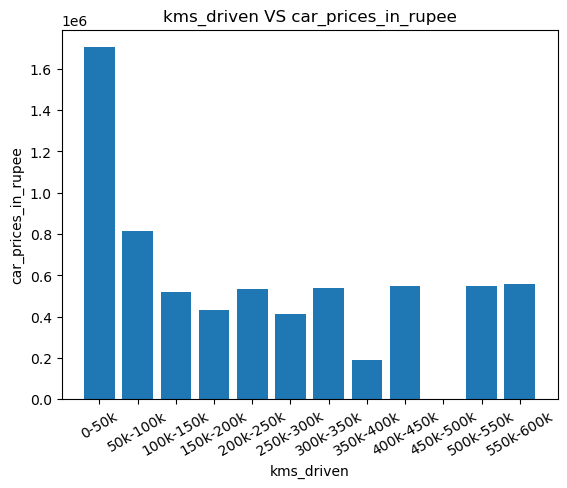

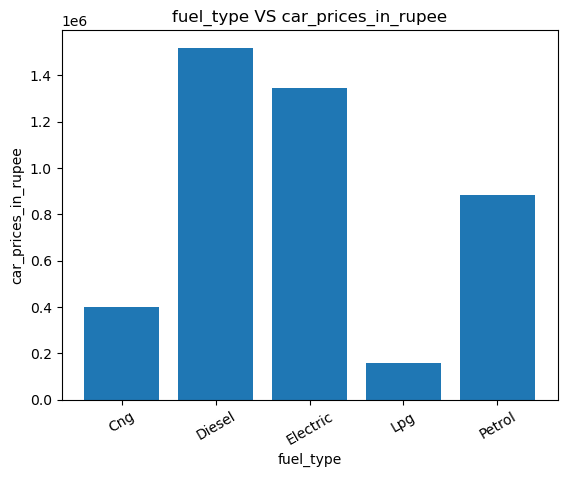

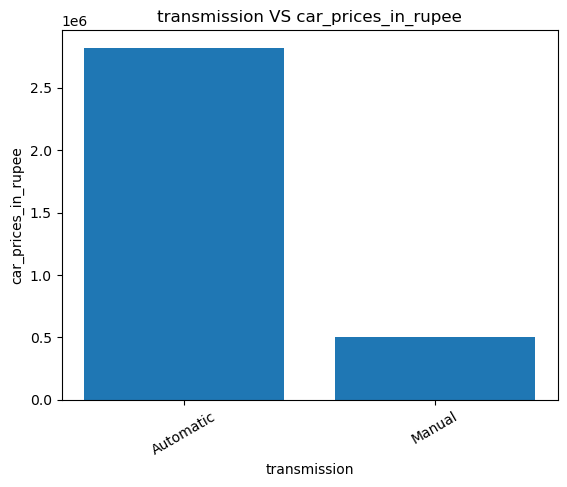

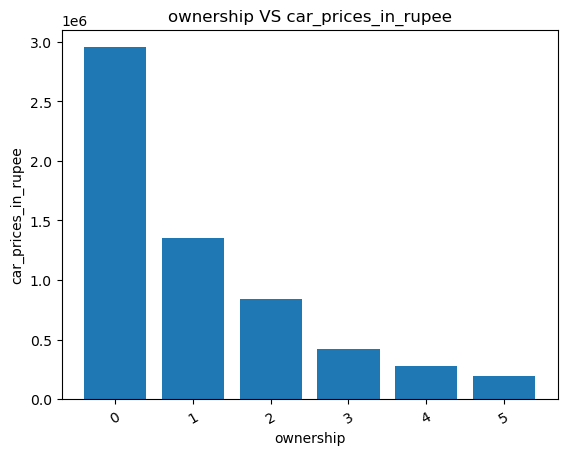

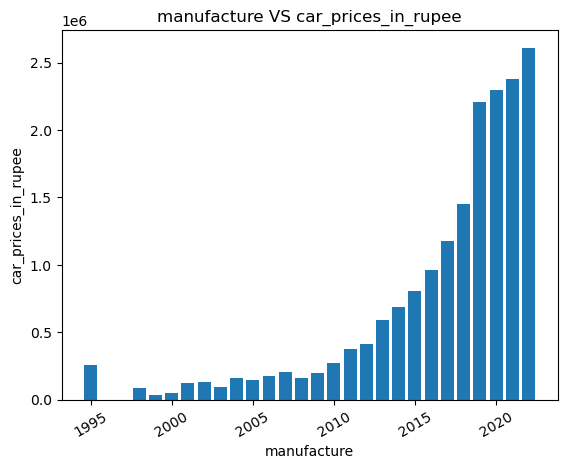

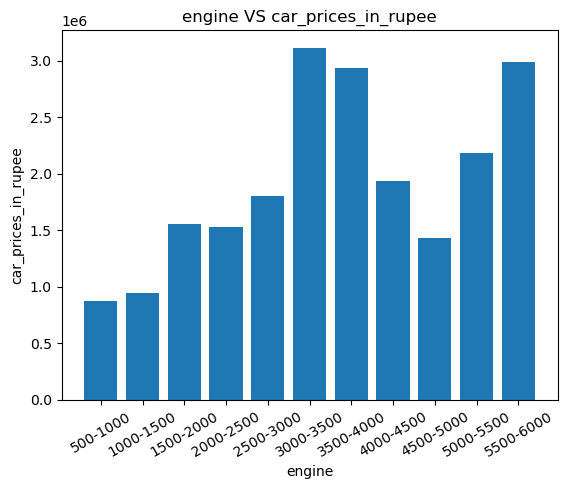

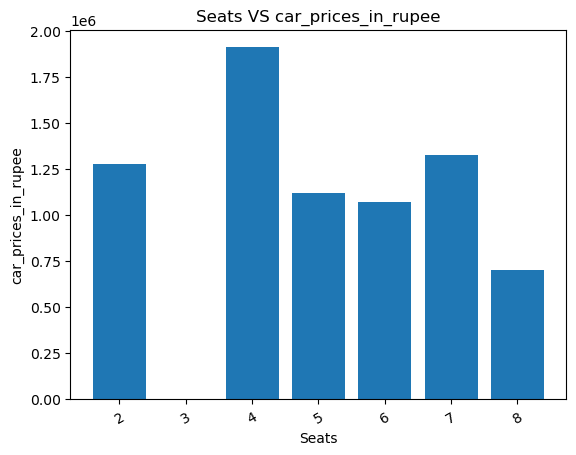

In [45]:
#Plot each column of df VS df['car_prices_in_rupee'] and analyse the results
columns_to_plot=['kms_driven', 'fuel_type', 'transmission','ownership', 'manufacture', 'engine', 'Seats']
for i in columns_to_plot:
    group_df = df_cars.groupby(i)["car_prices_in_rupee"].mean()
    plt.bar(group_df.index,group_df.values)
    plt.xlabel(f"{i}")
    plt.ylabel("car_prices_in_rupee")
    plt.title(f"{i} VS car_prices_in_rupee")
    plt.xticks(rotation=30)
    plt.show()

**From Above Graphs we infer that**

1. Lesser value of kms driven gives higher car price

2. Electric and Diesel cars are costlier than Cng and Lpg cars

3. Automatic car has more price than Manual

4. As number of owner increases, price decreases

5. Cars having latest year of manufacture have more price

6. Engine with more CC capacity has higher price

7. 4 seats car have more price

***Analyse Price Distribution***

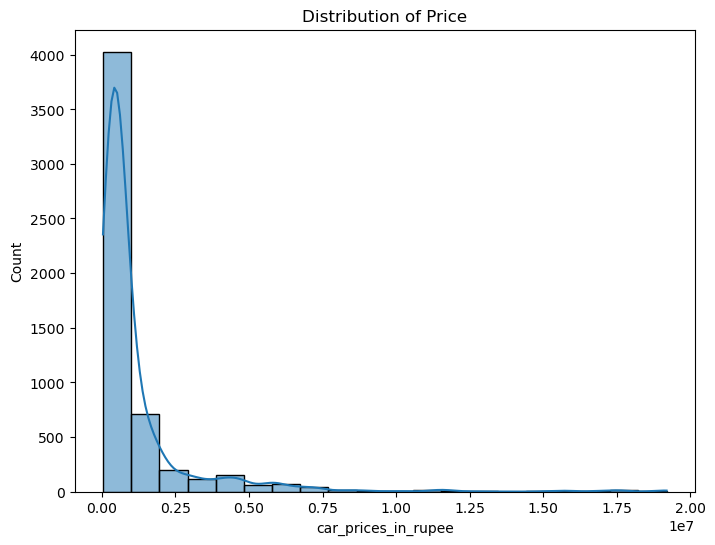

In [49]:
# Price Analysis
plt.figure(figsize=(8, 6))
sns.histplot(data=df_cars['car_prices_in_rupee'], bins=20, kde=True)
plt.title('Distribution of Price')
plt.show()

In [51]:
del df_cars

# Train the Model

**Extracting Training Data**

In [55]:
X = cars.drop(columns='car_prices_in_rupee',axis=1)
y = cars['car_prices_in_rupee'].to_numpy()

**Splitting data into training, validation and test data**

In [58]:
X_train_val,X_test,y_train_val,y_test=train_test_split(X,y,test_size=0.15,random_state=5)
X_train,X_val,y_train,y_val=train_test_split(X_train_val,y_train_val,test_size=0.15,random_state=6)

**Creating an OneHotEncoder for object to contain all the possible features**

In [61]:
categorical_columns=['car_name', 'fuel_type', 'transmission',]
numerical_columns=['kms_driven','ownership', 'manufacture','engine', 'Seats']

one_hot_encoder=OneHotEncoder(drop='first')
one_hot_encoded=one_hot_encoder.fit_transform(cars[categorical_columns])


df_one_hot_encoded=pd.DataFrame(one_hot_encoded.toarray(),columns=one_hot_encoder.get_feature_names_out())
df_x_features=pd.concat([df_one_hot_encoded,cars[numerical_columns]],axis=1)

**Standardization of feature columns**

In [64]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_x_features)
del df_x_features

**Creating a column transformer to transform categorical columns**

In [67]:
column_trans = make_column_transformer(
    (OneHotEncoder(categories=one_hot_encoder.categories_, drop='first',sparse_output=False), ['car_name', 'fuel_type', 'transmission']),
    remainder='passthrough'
)

**Creating a FunctionTransformer to wrap the already fitted scaler's transform method**

In [70]:
transformer = FunctionTransformer(scaler.transform, validate=True)

### Selection Of Model

****Apply model 1 from sklear LinearRegression****

In [74]:
# Makling a pipeline
pipe = make_pipeline(column_trans, transformer, LinearRegression())
# Fitting the data
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['Audi A3 35 TDI Premium', 'Audi A3 35 TDI Premium Plus',
       'Audi A4 1.8 TFSI', ..., 'Volvo XC60 D5 Summum',
       'Volvo XC60 Inscription D5', 'Volvo XC60 Inscription D5 BSIV'],
      dtype=object),
                                                                            array(['Cng', 'Diesel', 'Electric', 'Lpg', 'Petrol'], dtype=object),
                                                                            array(['Automatic', 'Manual'], dtype=object)],
                                                                drop='first',
                                                                sparse_output=False),
                                                  ['car_name', 'fuel_type',
                                                   'transmission'])])),
                ('functiontransformer',
                 FunctionTransformer(func=<bound method StandardScaler.transform of StandardScaler()>,
                                     validate=True)),
                ('linearregression', LinearRegression())])

****Calculating r2 scores****

In [76]:
y_pred1_train=pipe.predict(X_train)
r2_linear_train=r2_score(y_train,y_pred1_train)
print('r2_linear_train=',r2_linear_train.round(3))

y_pred1_val=pipe.predict(X_val)
r2_linear_val=r2_score(y_val,y_pred1_val)
print('r2_linear_val=',r2_linear_val.round(3))

y_pred1_test=pipe.predict(X_test)
r2_linear_test=r2_score(y_test,y_pred1_test)
print('r2_linear_test=',r2_linear_test.round(3))

r2_linear_train= 0.961
r2_linear_val= -7.028591375211639e+27
r2_linear_test= -4.2330594123280267e+27


****Apply model 2 from sklear SGDRegressor****

In [78]:
# Makling a pipeline
pipe = make_pipeline(column_trans, transformer, SGDRegressor(max_iter=1000))
# Fitting the data
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['Audi A3 35 TDI Premium', 'Audi A3 35 TDI Premium Plus',
       'Audi A4 1.8 TFSI', ..., 'Volvo XC60 D5 Summum',
       'Volvo XC60 Inscription D5', 'Volvo XC60 Inscription D5 BSIV'],
      dtype=object),
                                                                            array(['Cng', 'Diesel', 'Electric', 'Lpg', 'Petrol'], dtype=object),
                                                                            array(['Automatic', 'Manual'], dtype=object)],
                                                                drop='first',
                                                                sparse_output=False),
                                                  ['car_name', 'fuel_type',
                                                   'transmission'])])),
                ('functiontransformer',
                 FunctionTransformer(func=<bound method StandardScaler.transform of StandardScaler()>,
                                     validate=True)),
                ('sgdregressor', SGDRegressor())])

****Calculating r2 scores****

In [83]:
y_pred2_train=pipe.predict(X_train)
r2_train=r2_score(y_train,y_pred2_train)
print('r2_train=',r2_train.round(3))

y_pred2_val=pipe.predict(X_val)
r2_val=r2_score(y_val,y_pred2_val)
print('r2_val=',r2_val.round(3))

y_pred2_test=pipe.predict(X_test)
r2_test=r2_score(y_test,y_pred2_test)
print('r2_test=',r2_test.round(3))

r2_train= -11688339.098
r2_val= -3823.806
r2_test= -2340.961


****Apply Model 3 MyModel for LinearRegression****

In [86]:
# Makling a pipeline
pipe = make_pipeline(column_trans, transformer, MyModel(alpha=0.3))
# Fitting the data
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['Audi A3 35 TDI Premium', 'Audi A3 35 TDI Premium Plus',
       'Audi A4 1.8 TFSI', ..., 'Volvo XC60 D5 Summum',
       'Volvo XC60 Inscription D5', 'Volvo XC60 Inscription D5 BSIV'],
      dtype=object),
                                                                            array(['Cng', 'Diesel', 'Electric', 'Lpg', 'Petrol'], dtype=object),
                                                                            array(['Automatic', 'Manual'], dtype=object)],
                                                                drop='first',
                                                                sparse_output=False),
                                                  ['car_name', 'fuel_type',
                                                   'transmission'])])),
                ('functiontransformer',
                 FunctionTransformer(func=<bound method StandardScaler.transform of StandardScaler()>,
                                     validate=True)),
                ('mymodel',
                 <LinearRegressionModel.MyModel object at 0x000001CF0D9FF800>)])

****Calculating r2 scores****

In [88]:
y_pred3_train=pipe.predict(X_train)
r2_model3_train=r2_score(y_train.T,y_pred3_train.ravel())
print('r2_model3_train=',r2_model3_train.round(3))

y_pred3_val=pipe.predict(X_val)
r2_model3_val=r2_score(y_val.T,y_pred3_val.ravel())
print('r2_model3_val=',r2_model3_val.round(3))

y_pred3_test=pipe.predict(X_test)
r2_model3_test=r2_score(y_test.T,y_pred3_test.ravel())
print('r2_model3_test=',r2_model3_test.round(3))

r2_model3_train= 0.985
r2_model3_val= 0.928
r2_model3_test= 0.934


In [89]:
pipe.predict(pd.DataFrame(columns=['car_name','kms_driven', 'fuel_type', 'transmission','ownership', 'manufacture', 'engine', 'Seats'],data=np.array(['Honda Jazz VX CVT',26696.0,'Petrol','Automatic',1,2018,1199,5]).reshape(1,8)))

array([[727043.73589703]])

# Final Result

#### Model Performance
Model 3 achieved an R2 score of 93% on the test data, demonstrating strong predictive accuracy.

#### Conclusion
Given its impressive performance, Model 3 is considered as the best-performing model with an R2 score of 93%.

### Dumping the best model

In [93]:
pickle.dump(pipe,open('LinearRegressionModel.pkl','wb'))